# Побудова композитного індексу конкурентоспроможності країн

## 1. Огляд рішень

Композитні індикатори використовуються міжнародними організаціями для оцінювання багатовимірних явищ

**Основні етапи побудови:**
1. Нормалізація даних (Min-Max або Z-score)
2. Визначення ваг (рівні, експертні, PCA)
3. Агрегація (лінійна або геометрична)
4. Перевірка якості (кореляції, робастність)

## 2. Концептуальна модель

**Мета індексу:** Оцінка конкурентоспроможності/розвитку країн

**Індикатори (10 шт.):**
1. Access to electricity — інфраструктура (+)
2. Inflation — макроекономічна стабільність (-)
3. GDP PPP — економічний потенціал (+)
4. Rule of Law — інституції (+)
5. Life expectancy — людський капітал (+)
6. Tariff rate — торгова відкритість (-)
7. High-tech exports — інновації (+)
8. Imports of goods — інтеграція (+)
9. Health expenditure — соціальний розвиток (+)
10. CO2 emissions — екологія (-)

(+) — чим більше, тим краще

(-) — чим менше, тим краще (потрібно інвертувати)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
df = pd.read_csv('merged_world_bank_data.csv')

print(f"Розмір датасету: {df.shape}")
print(f"\nІндикатори в датасеті:")
for indicator in df['Indicator Name'].unique():
    print(f"  - {indicator}")

Розмір датасету: (2547, 69)

Індикатори в датасеті:
  - Access to electricity (% of population)
  - Inflation, consumer prices (annual %)
  - GDP, PPP (current international $)
  - Rule of Law: Estimate
  - Life expectancy at birth, total (years)
  - Tariff rate, applied, weighted mean, all products (%)
  - High-technology exports (% of manufactured exports)
  - Imports of goods and services (% of GDP)
  - Current health expenditure (% of GDP)
  - Annual CO2 emissions


In [3]:
countries = df['Country Name'].unique()

print(f"Всього об'єктів: {len(countries)}\n")


print("ВСІ КРАЇНИ/ОБ'ЄКТИ (початковий датасет):")


for i, country in enumerate(sorted(countries), 1):
    print(f"{i:3}. {country}")

Всього об'єктів: 306

ВСІ КРАЇНИ/ОБ'ЄКТИ (початковий датасет):
  1. Afghanistan
  2. Africa Eastern and Southern
  3. Africa Western and Central
  4. Albania
  5. Algeria
  6. American Samoa
  7. Andorra
  8. Angola
  9. Anguilla
 10. Antarctica
 11. Antigua and Barbuda
 12. Arab World
 13. Argentina
 14. Armenia
 15. Aruba
 16. Australia
 17. Austria
 18. Azerbaijan
 19. Bahamas
 20. Bahamas, The
 21. Bahrain
 22. Bangladesh
 23. Barbados
 24. Belarus
 25. Belgium
 26. Belize
 27. Benin
 28. Bermuda
 29. Bhutan
 30. Bolivia
 31. Bonaire Sint Eustatius and Saba
 32. Bosnia and Herzegovina
 33. Botswana
 34. Brazil
 35. British Virgin Islands
 36. Brunei
 37. Brunei Darussalam
 38. Bulgaria
 39. Burkina Faso
 40. Burundi
 41. Cabo Verde
 42. Cambodia
 43. Cameroon
 44. Canada
 45. Cape Verde
 46. Caribbean small states
 47. Cayman Islands
 48. Central African Republic
 49. Central Europe and the Baltics
 50. Chad
 51. Channel Islands
 52. Chile
 53. China
 54. Christmas Island
 55. Colo

## 3. Очищення даних від агрегатів

Видаляємо групи World Bank (регіони, групи по доходу тощо), залишаємо тільки реальні країни.

In [4]:
aggregates_to_remove = [
    #групи по доходу
    'High income',
    'Upper middle income',
    'Middle income',
    'Lower middle income',
    'Low & middle income',
    'Low income',
    
    #регіони
    'North America',
    'Europe & Central Asia',
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Latin America & Caribbean (excluding high income)',
    'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Middle East and North Africa',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'Middle East, North Africa, Afghanistan & Pakistan (excluding high income)',
    'Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (excluding high income)',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'Africa Western and Central',
    'Africa Eastern and Southern',
    'Central Europe and the Baltics',
    'Arab World',
    
    #організації та класифікації
    'OECD members',
    'European Union',
    'Euro area',
    'World',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA total',
    'IDA only',
    
    #демографічні групи
    'Post-demographic dividend',
    'Late-demographic dividend',
    'Early-demographic dividend',
    'Pre-demographic dividend',
    
    #інші класифікації
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'Least developed countries: UN classification',
    'Small states',
    'Other small states',
    'Caribbean small states',
    'Pacific island small states',
    'Not classified',
    
    #території без повних даних
    'Christmas Island',
    'Antarctica',
    'Niue',
    'Saint Helena',
    'Wallis and Futuna',
    'Montserrat',
    'Saint Pierre and Miquelon',
    'Cook Islands',
    'Bonaire Sint Eustatius and Saba',
    'Anguilla'
]

print(f"Рядків до очищення: {len(df)}")
print(f"Унікальних країн/об'єктів до очищення: {df['Country Name'].nunique()}")

#видаляємо агрегати
df_clean = df[~df['Country Name'].isin(aggregates_to_remove)].copy()

print(f"\nРядків після очищення: {len(df_clean)}")
print(f"Унікальних країн після очищення: {df_clean['Country Name'].nunique()}")
print(f"Видалено об'єктів: {df['Country Name'].nunique() - df_clean['Country Name'].nunique()}")

Рядків до очищення: 2547
Унікальних країн/об'єктів до очищення: 306

Рядків після очищення: 2132
Унікальних країн після очищення: 246
Видалено об'єктів: 60


In [5]:
duplicates_to_remove = [
    'South Korea',           
    'North Korea',           
    'Russia',          
    'Egypt',               
    'Iran',                 
    'Venezuela',            
    'Yemen',             
    'Laos',              
    'Vietnam',            
    'Syria',                
    'Congo',                
    'Democratic Republic of Congo',  
    'Gambia',             
    'Bahamas',              
    'Kyrgyzstan',           
    'Slovakia',             
    'Brunei',              
    'Cape Verde',           
    'Turkey',               
    'East Timor',           
    'Macao',                
    'Hong Kong',             
    'Taiwan',                
    'Palestine',         
    'Somalia',              
    'Ivory Coast',           
    'Swaziland',             
    'Saint Lucia',          
    'Saint Kitts and Nevis', 
    'Saint Vincent and the Grenadines',  
    'Micronesia (country)', 
]

print(f"Країн до видалення дублікатів: {df_clean['Country Name'].nunique()}")

#видаляємо дублікати
df_clean = df_clean[~df_clean['Country Name'].isin(duplicates_to_remove)].copy()

#перевіряємо скільки реально видалено
removed_count = len([d for d in duplicates_to_remove if d in df['Country Name'].unique()])
print(f"Видалено дублікатів: {removed_count}")
print(f"Країн після видалення дублікатів: {df_clean['Country Name'].nunique()}")

Країн до видалення дублікатів: 246
Видалено дублікатів: 29
Країн після видалення дублікатів: 217


In [6]:
#визначаємо колонки з роками
year_columns = [col for col in df_clean.columns if col.isdigit()]
print(f"Доступні роки: {year_columns[0]} - {year_columns[-1]}")
print(f"Всього років: {len(year_columns)}")

#аналіз наявності даних по роках для кожного індикатора
indicators = df_clean['Indicator Name'].unique()

#рахуємо кількість непорожніх значень
year_coverage = {}
for year in year_columns:
    year_coverage[year] = {}
    for indicator in indicators:
        indicator_data = df_clean[df_clean['Indicator Name'] == indicator][year]
        non_null_count = indicator_data.notna().sum()
        year_coverage[year][indicator] = non_null_count

coverage_df = pd.DataFrame(year_coverage).T
coverage_df.index.name = 'Year'

print("\nКількість країн з даними по роках (останні 20 років):")
print(coverage_df.tail(20))

Доступні роки: 1960 - 2024
Всього років: 65

Кількість країн з даними по роках (останні 20 років):
      Access to electricity (% of population)  \
Year                                            
2005                                      212   
2006                                      212   
2007                                      214   
2008                                      214   
2009                                      215   
2010                                      215   
2011                                      215   
2012                                      215   
2013                                      215   
2014                                      215   
2015                                      215   
2016                                      215   
2017                                      215   
2018                                      215   
2019                                      215   
2020                                      215   
2021               

In [7]:
#знаходимо роки з даними для всіх індикаторів
min_countries = 50

valid_years = []
for year in year_columns:
    all_have_data = all(coverage_df.loc[year] >= min_countries)
    if all_have_data:
        valid_years.append(year)

print(f"Роки з даними для всіх індикаторів (мін. {min_countries} країн): {len(valid_years)}")

#вибираємо 15 найновіших років
if len(valid_years) >= 15:
    selected_years = valid_years[-15:]
else:
    selected_years = valid_years
    print(f"Увага: знайдено тільки {len(valid_years)} років")

print(f"\nВибрані 15 років: {selected_years}")

Роки з даними для всіх індикаторів (мін. 50 країн): 15

Вибрані 15 років: ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [8]:
#створюємо відфільтрований датасет
base_columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
columns_to_keep = base_columns + selected_years

filtered_df = df_clean[columns_to_keep].copy()

print(f"Розмір відфільтрованого датасету: {filtered_df.shape}")

Розмір відфільтрованого датасету: (2103, 19)


## 4. Видалення 10% країн з найбільшою кількістю пропусків

In [9]:
#рахуємо пропуски для кожної країни
country_missing = {}

for country in filtered_df['Country Name'].unique():
    country_data = filtered_df[filtered_df['Country Name'] == country][selected_years]
    missing_count = country_data.isna().sum().sum()
    total_count = country_data.size
    missing_pct = (missing_count / total_count) * 100
    country_missing[country] = {
        'missing': missing_count,
        'total': total_count,
        'pct': missing_pct
    }

#створюємо DataFrame і сортуємо по пропусках
missing_df = pd.DataFrame(country_missing).T
missing_df = missing_df.sort_values('pct', ascending=False)

print("ТОП-20 країн з найбільшими пропусками:")
print(missing_df.head(20))

#визначаємо 10% для видалення
n_countries = len(missing_df)
n_to_remove = int(n_countries * 0.10)

countries_to_remove = missing_df.head(n_to_remove).index.tolist()

print(f"\nВсього країн: {n_countries}")
print(f"Видаляємо 10% ({n_to_remove} країн) з найбільшими пропусками")
print(f"\nКраїни для видалення:")
for i, country in enumerate(countries_to_remove, 1):
    pct = missing_df.loc[country, 'pct']
    print(f"  {i}. {country} ({pct:.1f}% пропусків)")

ТОП-20 країн з найбільшими пропусками:
                           missing  total        pct
Channel Islands               90.0  120.0  75.000000
Gibraltar                     90.0  120.0  75.000000
Isle of Man                   90.0  120.0  75.000000
St. Martin (French part)      90.0  120.0  75.000000
British Virgin Islands        90.0  135.0  66.666667
Korea, Dem. People's Rep.     77.0  120.0  64.166667
Northern Mariana Islands      75.0  120.0  62.500000
American Samoa                75.0  120.0  62.500000
Monaco                        76.0  135.0  56.296296
Liechtenstein                 75.0  135.0  55.555556
Turks and Caicos Islands      73.0  135.0  54.074074
Sint Maarten (Dutch part)     70.0  135.0  51.851852
Guam                          60.0  120.0  50.000000
New Caledonia                 65.0  135.0  48.148148
Eritrea                       65.0  150.0  43.333333
Faroe Islands                 58.0  135.0  42.962963
Somalia, Fed. Rep.            50.0  120.0  41.666667
South S

In [10]:
#видаляємо країни з найбільшими пропусками
print(f"Рядків до видалення: {len(filtered_df)}")

filtered_df = filtered_df[~filtered_df['Country Name'].isin(countries_to_remove)].copy()

print(f"Рядків після видалення: {len(filtered_df)}")
print(f"Залишилось країн: {filtered_df['Country Name'].nunique()}")

Рядків до видалення: 2103
Рядків після видалення: 1921
Залишилось країн: 196


## 5. Заповнення пропусків

Використовуємо комбінований підхід:
1. Лінійна інтерполяція
2. Forward/Backward fill
3. Медіана по індикатору

In [11]:
#підрахунок пропусків до заповнення
print("Пропуски до заповнення:")

missing_before = {}
for indicator in indicators:
    ind_data = filtered_df[filtered_df['Indicator Name'] == indicator][selected_years]
    missing = ind_data.isna().sum().sum()
    total = ind_data.size
    pct = (missing / total) * 100
    missing_before[indicator] = missing
    print(f"{indicator[:50]:50s}: {missing:4d} ({pct:5.1f}%)")

total_missing_before = sum(missing_before.values())
print(f"\nЗагальна кількість пропусків: {total_missing_before}")

Пропуски до заповнення:
Access to electricity (% of population)           :   15 (  0.5%)
Inflation, consumer prices (annual %)             :  408 ( 13.9%)
GDP, PPP (current international $)                :   55 (  1.9%)
Rule of Law: Estimate                             :   33 (  1.1%)
Life expectancy at birth, total (years)           :    0 (  0.0%)
Tariff rate, applied, weighted mean, all products :  709 ( 24.1%)
High-technology exports (% of manufactured exports:  753 ( 25.6%)
Imports of goods and services (% of GDP)          :  321 ( 10.9%)
Current health expenditure (% of GDP)             :   32 (  1.2%)
Annual CO2 emissions                              :    0 (  0.0%)

Загальна кількість пропусків: 2326


In [12]:

def fill_missing_values(df, year_cols):
    df_filled = df.copy()
    
    for indicator in df['Indicator Name'].unique():
        mask = df_filled['Indicator Name'] == indicator
        
        #крок 1: Лінійна інтерполяція
        df_filled.loc[mask, year_cols] = df_filled.loc[mask, year_cols].interpolate(
            method='linear', axis=1, limit_direction='both'
        )
        
        #крок 2: Forward/Backward fill
        df_filled.loc[mask, year_cols] = df_filled.loc[mask, year_cols].ffill(axis=1).bfill(axis=1)
        
        #крок 3: Медіана по індикатору
        for year in year_cols:
            median_val = df_filled.loc[mask, year].median()
            df_filled.loc[mask, year] = df_filled.loc[mask, year].fillna(median_val)
    
    return df_filled

filled_df = fill_missing_values(filtered_df, selected_years)

In [13]:
#підрахунок пропусків пілся заповнення
print("Пропуски пілся заповнення:")

missing_after = {}
for indicator in indicators:
    ind_data = filled_df[filled_df['Indicator Name'] == indicator][selected_years]
    missing = ind_data.isna().sum().sum()
    missing_after[indicator] = missing
    filled_count = missing_before[indicator] - missing
    print(f"{indicator[:50]:50s}: {missing:4d} [заповнено: {filled_count}]")

total_missing_after = sum(missing_after.values())
total_filled = total_missing_before - total_missing_after
print(f"\nЗагальна кількість пропусків: {total_missing_after}")
print(f"Всього заповнено: {total_filled} значень")

Пропуски пілся заповнення:
Access to electricity (% of population)           :    0 [заповнено: 15]
Inflation, consumer prices (annual %)             :    0 [заповнено: 408]
GDP, PPP (current international $)                :    0 [заповнено: 55]
Rule of Law: Estimate                             :    0 [заповнено: 33]
Life expectancy at birth, total (years)           :    0 [заповнено: 0]
Tariff rate, applied, weighted mean, all products :    0 [заповнено: 709]
High-technology exports (% of manufactured exports:    0 [заповнено: 753]
Imports of goods and services (% of GDP)          :    0 [заповнено: 321]
Current health expenditure (% of GDP)             :    0 [заповнено: 32]
Annual CO2 emissions                              :    0 [заповнено: 0]

Загальна кількість пропусків: 0
Всього заповнено: 2326 значень


In [14]:
#зберігаємо очищений датасет
output_filename = 'filtered_data.csv'
filled_df.to_csv(output_filename, index=False)

print(f"Датасет збережено: {output_filename}")
print(f"\nПідсумок:")
print(f"  - Кількість записів: {len(filled_df)}")
print(f"  - Кількість країн: {filled_df['Country Name'].nunique()}")
print(f"  - Кількість років: {len(selected_years)}")
print(f"  - Роки: {selected_years[0]} - {selected_years[-1]}")

Датасет збережено: filtered_data.csv

Підсумок:
  - Кількість записів: 1921
  - Кількість країн: 196
  - Кількість років: 15
  - Роки: 2007 - 2021


## 6. Підготовка даних для аналізу

In [15]:
#створюємо pivot таблицю: країни × індикатори
pivot_df = filled_df.groupby(['Country Name', 'Indicator Name'])[selected_years].mean().mean(axis=1).unstack()

print(f"Розмір pivot таблиці: {pivot_df.shape}")
print(f"Пропусків: {pivot_df.isna().sum().sum()}")

#заповнюємо залишкові пропуски медіаною
df_filled = pivot_df.copy()
for col in df_filled.columns:
    median_val = df_filled[col].median()
    null_count = df_filled[col].isna().sum()
    df_filled[col] = df_filled[col].fillna(median_val)
    if null_count > 0:
        print(f"  {col[:40]}: заповнено {null_count} значень")

print(f"\nПропусків після: {df_filled.isna().sum().sum()}")
print(f"Країн: {len(df_filled)}")

#відсоток заповнених даних
total_values = pivot_df.size
missing_values = pivot_df.isna().sum().sum()
print(f"\nЗаповнено: {missing_values} з {total_values} ({missing_values/total_values*100:.1f}%)")

Розмір pivot таблиці: (196, 10)
Пропусків: 39
  Annual CO2 emissions: заповнено 28 значень
  Current health expenditure (% of GDP): заповнено 11 значень

Пропусків після: 0
Країн: 196

Заповнено: 39 з 1960 (2.0%)


## 7. Кореляційний аналіз

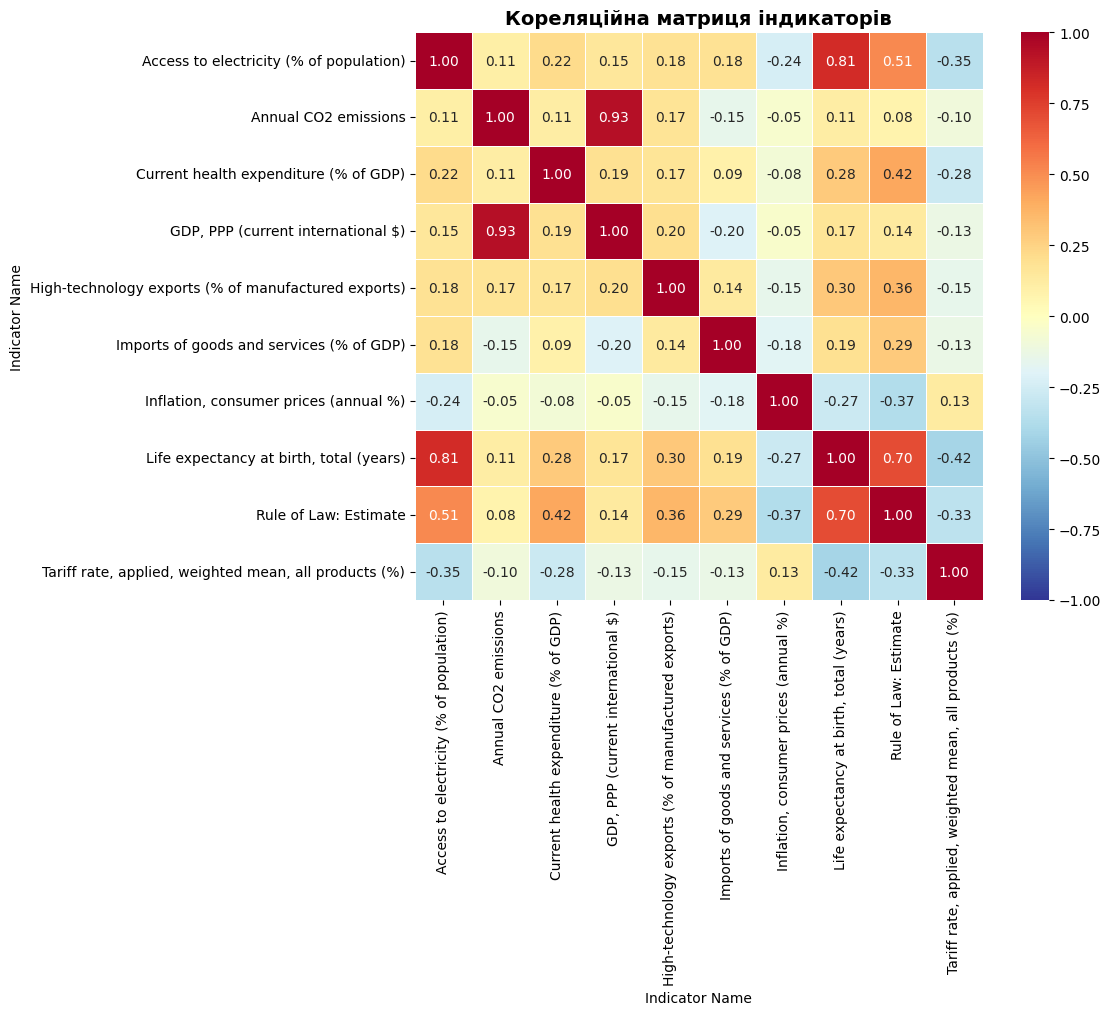

In [16]:
corr_matrix = df_filled.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Кореляційна матриця індикаторів', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Кореляційна матриця показує логічні взаємозв'язки між індикаторами. Найсильніша кореляція спостерігається між викидами CO2 та ВВП (0.93), що очікувано для великих економік. Тривалість життя тісно пов'язана з доступом до електрики (0.81) та верховенством права (0.70), що підтверджує зв'язок інфраструктури й інституцій зі здоров'ям населення.
Негативні кореляції також логічні: тривалість життя від'ємно корелює з тарифами (-0.42), а інфляція — з верховенством права (-0.37). Це свідчить про те, що відкриті економіки з сильними інституціями мають кращі соціальні показники.

## 8. Інвертування негативних індикаторів

In [17]:
negative_indicators = [
    'Inflation, consumer prices (annual %)',
    'Tariff rate, applied, weighted mean, all products (%)',
    'Annual CO2 emissions'
]

df_inverted = df_filled.copy()
for ind in negative_indicators:
    if ind in df_inverted.columns:
        df_inverted[ind] = -df_inverted[ind]
        print(f"Інвертовано: {ind}")

print(f"\nПропусків: {df_inverted.isna().sum().sum()}")
print(f"Країн: {len(df_inverted)}")

Інвертовано: Inflation, consumer prices (annual %)
Інвертовано: Tariff rate, applied, weighted mean, all products (%)
Інвертовано: Annual CO2 emissions

Пропусків: 0
Країн: 196


## 9. PCA для визначення ваг

In [18]:
# 1.стандартизація (Z-score)
scaler = StandardScaler()
df_standardized = pd.DataFrame(
    scaler.fit_transform(df_inverted),
    index=df_inverted.index,
    columns=df_inverted.columns
)

# 2.PCA
pca = PCA()
pca_result = pca.fit(df_standardized)

# 3.пояснена дисперсія

print("ПОЯСНЕНА ДИСПЕРСІЯ ПО КОМПОНЕНТАХ:")

cumulative_var = 0
for i, var in enumerate(pca.explained_variance_ratio_):
    cumulative_var += var
    print(f"PC{i+1}: {var*100:6.2f}% | Кумулятивно: {cumulative_var*100:6.2f}%")

# 4. Кількість компонент (≥70%)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.70) + 1
print(f"\nОбрано компонент (≥70% дисперсії): {n_components}")

ПОЯСНЕНА ДИСПЕРСІЯ ПО КОМПОНЕНТАХ:
PC1:  33.11% | Кумулятивно:  33.11%
PC2:  19.59% | Кумулятивно:  52.70%
PC3:   9.90% | Кумулятивно:  62.60%
PC4:   9.20% | Кумулятивно:  71.81%
PC5:   8.03% | Кумулятивно:  79.84%
PC6:   7.58% | Кумулятивно:  87.42%
PC7:   6.94% | Кумулятивно:  94.36%
PC8:   3.72% | Кумулятивно:  98.08%
PC9:   1.34% | Кумулятивно:  99.42%
PC10:   0.58% | Кумулятивно: 100.00%

Обрано компонент (≥70% дисперсії): 4


In [19]:
# 5.факторні навантаження
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_inverted.columns,
    columns=[f'PC{i+1}' for i in range(len(df_inverted.columns))]
)

print("ФАКТОРНІ НАВАНТАЖЕННЯ (перші 3 компоненти):")

print(loadings.iloc[:, :3].round(3))

# 6.розрахунок ваг на основі PCA
selected_loadings = loadings.iloc[:, :n_components]
variance_weights = pca.explained_variance_ratio_[:n_components]

weights_raw = (selected_loadings ** 2).multiply(variance_weights, axis=1).sum(axis=1)
weights_normalized = weights_raw / weights_raw.sum()

print("\n" + "=" * 50)
print("ВАГИ ІНДИКАТОРІВ (PCA-based):")

weights_df = pd.DataFrame({
    'Індикатор': weights_normalized.index,
    'Вага': weights_normalized.values,
    'Вага (%)': weights_normalized.values * 100
}).sort_values('Вага', ascending=False)

for _, row in weights_df.iterrows():
    print(f"{row['Індикатор'][:45]:.<50} {row['Вага (%)']:5.2f}%")

print(f"\nСума ваг: {weights_normalized.sum():.4f}")

ФАКТОРНІ НАВАНТАЖЕННЯ (перші 3 компоненти):
                                                      PC1    PC2    PC3
Indicator Name                                                         
Access to electricity (% of population)             0.418  0.117 -0.238
Annual CO2 emissions                               -0.185  0.635 -0.132
Current health expenditure (% of GDP)               0.276 -0.025 -0.275
GDP, PPP (current international $)                  0.217 -0.634  0.065
High-technology exports (% of manufactured expo...  0.261 -0.053  0.452
Imports of goods and services (% of GDP)            0.159  0.349  0.381
Inflation, consumer prices (annual %)               0.236  0.123  0.549
Life expectancy at birth, total (years)             0.473  0.126 -0.183
Rule of Law: Estimate                               0.448  0.151  0.080
Tariff rate, applied, weighted mean, all produc...  0.306  0.048 -0.394

ВАГИ ІНДИКАТОРІВ (PCA-based):
GDP, PPP (current international $)................ 13.20%
Ann

## 10. Побудова композитного індексу

In [20]:
# 1.нормалізація Min-Max (0-1)
scaler_minmax = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler_minmax.fit_transform(df_inverted),
    index=df_inverted.index,
    columns=df_inverted.columns
)

# 2.зважена сума (PCA-ваги)
composite_pca = (df_normalized * weights_normalized).sum(axis=1)

# 3.масштабування на 0-100
composite_pca_100 = 100 * (composite_pca - composite_pca.min()) / \
                    (composite_pca.max() - composite_pca.min())

# 4.результати
result_df = pd.DataFrame({
    'Country': composite_pca_100.index,
    'Composite_Index': composite_pca_100.values
}).sort_values('Composite_Index', ascending=False).reset_index(drop=True)

# 5.виведення результатів
print("ТОП-20 КРАЇН ЗА КОМПОЗИТНИМ ІНДЕКСОМ:")
print(result_df.head(20).to_string(index=False))

print("\nBOTTOM-10 КРАЇН:")
print(result_df.tail(10).to_string(index=False))


ТОП-20 КРАЇН ЗА КОМПОЗИТНИМ ІНДЕКСОМ:
             Country  Composite_Index
       United States       100.000000
Hong Kong SAR, China        95.642068
           Singapore        93.869215
         Switzerland        87.974240
         Netherlands        87.873577
               Malta        87.339569
              France        87.152925
             Ireland        86.551038
             Germany        86.197305
               Japan        84.479517
      United Kingdom        84.451278
              Sweden        84.250000
             Austria        83.145195
             Denmark        83.130268
              Canada        83.020227
             Belgium        82.753569
              Norway        82.436801
          San Marino        82.368998
             Iceland        82.063045
          Luxembourg        82.039110

BOTTOM-10 КРАЇН:
                 Country  Composite_Index
                  Angola        15.178369
                 Nigeria        14.581770
           Guinea-Bi

## 11. Візуалізація результатів

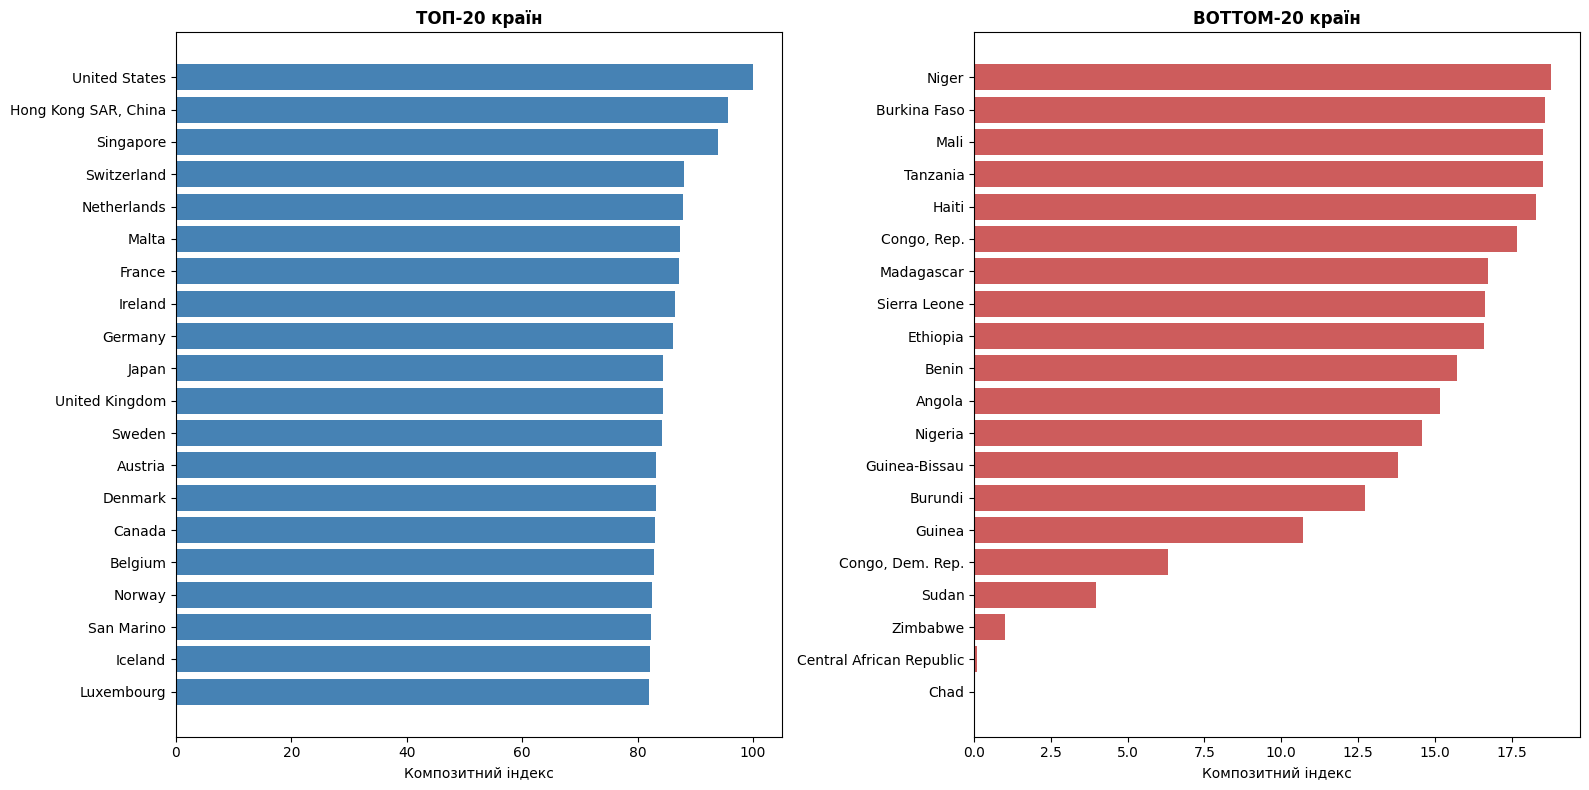

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

#ТОП-20
top20 = result_df.head(20)
axes[0].barh(top20['Country'], top20['Composite_Index'], color='steelblue')
axes[0].set_xlabel('Композитний індекс')
axes[0].set_title('ТОП-20 країн', fontweight='bold')
axes[0].invert_yaxis()

#BOTTOM-20
bottom20 = result_df.tail(20)
axes[1].barh(bottom20['Country'], bottom20['Composite_Index'], color='indianred')
axes[1].set_xlabel('Композитний індекс')
axes[1].set_title('BOTTOM-20 країн', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

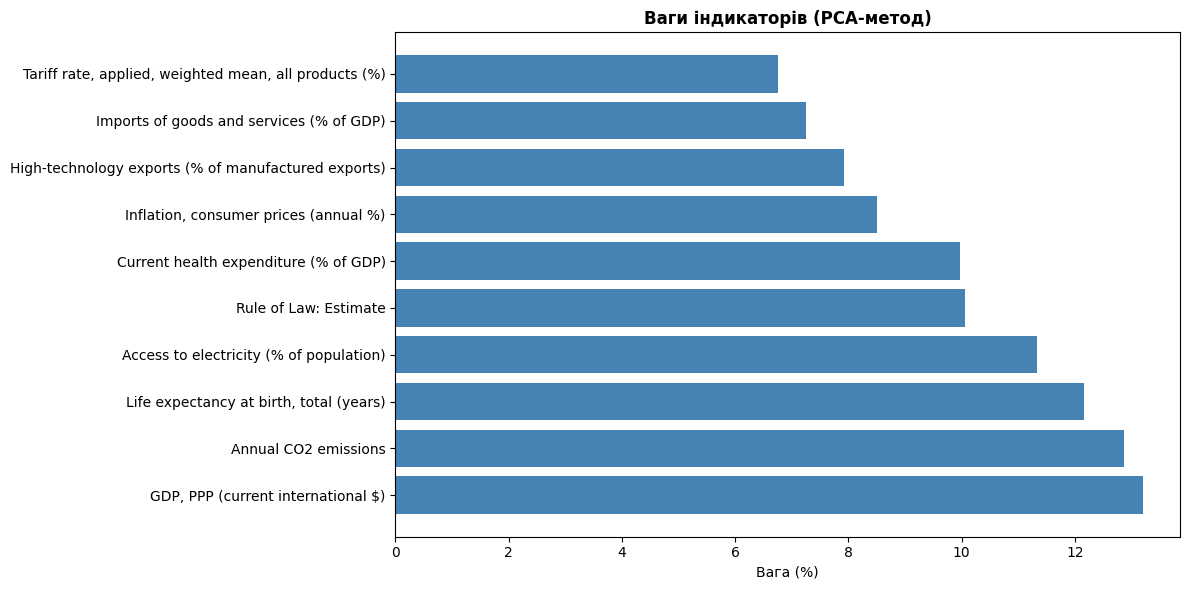

In [22]:
#візуалізація ваг індикаторів
plt.figure(figsize=(12, 6))
plt.barh(weights_df['Індикатор'], weights_df['Вага (%)'], color='steelblue')
plt.xlabel('Вага (%)')
plt.title('Ваги індикаторів (PCA-метод)', fontweight='bold')
plt.tight_layout()
plt.show()

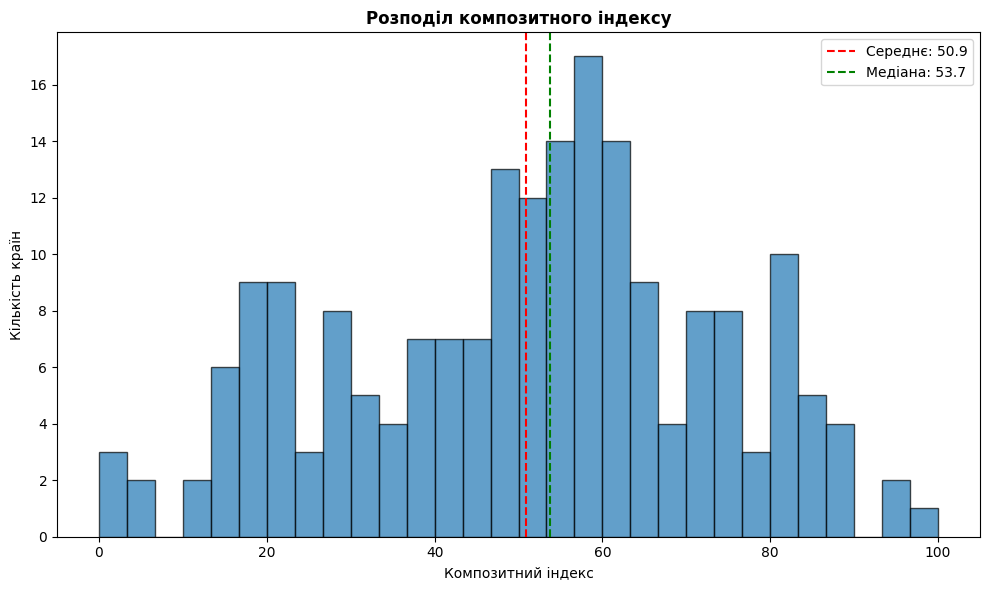

In [23]:
#розподіл індексу
plt.figure(figsize=(10, 6))
plt.hist(result_df['Composite_Index'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Композитний індекс')
plt.ylabel('Кількість країн')
plt.title('Розподіл композитного індексу', fontweight='bold')
plt.axvline(result_df['Composite_Index'].mean(), color='red', linestyle='--', label=f"Середнє: {result_df['Composite_Index'].mean():.1f}")
plt.axvline(result_df['Composite_Index'].median(), color='green', linestyle='--', label=f"Медіана: {result_df['Composite_Index'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()

## 12. Фінальний підсумок

In [24]:
print("ФІНАЛЬНИЙ ПІДСУМОК")
print(f"\nДані:")
print(f"  - Країн: {len(result_df)}")
print(f"  - Індикаторів: {len(weights_normalized)}")
print(f"  - Період: {selected_years[0]} - {selected_years[-1]} ({len(selected_years)} років)")
print(f"\nPCA:")
print(f"  - Компонент для 70% дисперсії: {n_components}")
print(f"\nІндекс:")
print(f"  - Мін: {result_df['Composite_Index'].min():.2f}")
print(f"  - Макс: {result_df['Composite_Index'].max():.2f}")
print(f"  - Середнє: {result_df['Composite_Index'].mean():.2f}")
print(f"  - Медіана: {result_df['Composite_Index'].median():.2f}")

ФІНАЛЬНИЙ ПІДСУМОК

Дані:
  - Країн: 196
  - Індикаторів: 10
  - Період: 2007 - 2021 (15 років)

PCA:
  - Компонент для 70% дисперсії: 4

Індекс:
  - Мін: 0.00
  - Макс: 100.00
  - Середнє: 50.88
  - Медіана: 53.73
